In [1]:
import numpy as np
from QAM_EncoderDecoder import * 
import commpy
from scipy.io.wavfile import write, read
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
from scipy.signal import csd, chirp
import binascii
from scipy.signal import correlate
from IPython.display import Audio
%matplotlib inline

In [2]:
N = 2048 # for dft length, no symbols
prefix_no = 256
fs = 44100

#random_symbol = np.random.randint(0,100, int(N/4)) # easier to test if same every time
# NEED TO CHANGE TO PSEUDO RANDOM SIGNALS
random_symbol = np.array([81, 41, 51, 46, 19, 27, 84, 53,  0, 86, 54, 17, 33, 32,  8, 24, 19,
       38, 58, 28, 74, 10, 39, 24, 39, 22, 59, 58, 70, 74, 82, 64,  4, 77,
       98, 50, 26, 36, 21, 32, 56, 27, 92, 42, 63, 91, 67, 76, 65, 40, 17,
       49, 66, 42, 87, 20, 50, 89, 48, 47, 40, 29, 57, 40, 92, 73,  8, 26,
       12, 76, 24, 82, 43, 14, 40, 19, 56, 97, 78, 43, 96, 43, 89,  6, 11,
       98, 58, 25, 91, 16, 40, 77, 52,  9, 34, 45, 36, 69, 12, 29, 38, 45,
       88, 14, 20, 49,  1, 61, 48, 36, 10, 44, 44,  5,  7, 34, 26, 72,  7,
       63, 68, 27, 12, 71, 39, 54, 96,  1, 70, 67, 76, 30, 77, 73, 28, 88,
       31, 17, 86, 62,  1, 12, 35, 74,  3, 87, 73, 26, 83, 73,  6,  3, 32,
       37, 39, 53, 90, 88, 60, 89, 93, 91,  4, 53,  5,  4,  4, 58, 35, 63,
       27, 77, 51, 87, 24, 31, 16,  4, 87, 98, 52, 90, 68, 37, 75, 56, 34,
       30, 50, 26, 20, 96, 51, 94, 60, 55, 14, 74,  4, 73, 13, 45, 67,  8,
       61, 12, 93,  6, 87, 14, 90, 64, 33, 29, 68, 13, 60, 18,  9, 60,  3,
       15,  6, 48, 34, 44, 63, 25, 39, 18,  5, 56, 38, 46,  6, 64, 36, 29,
       90, 47, 23, 29, 97, 19,  5, 47, 30, 63, 98, 99, 20, 91, 69, 24, 35,
       59])

about to do encode_bitstr2symbols encoding
encode_bitstr2symbols encoding finished
1024
1025
2048
[ 0.02735566+0.j  0.00185324+0.j  0.00961595+0.j ...  0.01507947+0.j
 -0.00575321+0.j  0.24583072+0.j]
(1, 2304)
[-4.4408921e-15 +0.j -1.0000000e+01+10.j -1.0000000e+01+10.j ...
  1.0000000e+01-10.j -1.0000000e+01-10.j -1.0000000e+01-10.j]


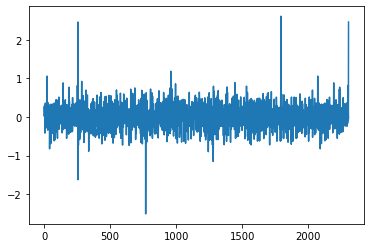

In [3]:
bin_strings=''
for byte in random_symbol:
    binary_string = '{0:08b}'.format(byte)
    bin_strings+=binary_string

symbols = encode_bitstr2symbols(bin_strings)
symbols = symbols[:N//2-1] # reduced num info bins to 256 so need fewer symbols for a single OFDM symbol

# change info bins to just 256 corresponding to ~ 11kHz
info_bins=int(N//2)-1 # so here now 256 info bins - same as num symbols -> so one OFDM symbol
OFDM_frames=[]

# start from 3rd bin (~82 Hz onward) too??

OFDM_frames = []
# for each OFDM block

for i in range (0,len(symbols),info_bins):
    OFDM_block=[0] #frequency bins 0 and 512(int(N/2)) contains value 0
    # start from 3rd bin? depends on bandwidth, N etc.
    OFDM_block[1:]=symbols[i:i+info_bins]
    print(len(OFDM_block))
    #add 0s to the end when data is not an integer factor of 512
    while len(OFDM_block)<=((N/2)): # change from info_bins as thats now reduced - crucial for conjugate symmetry
        OFDM_block.append(0)
    # merge lines above/below?
    #OFDM_block.append(0)#frequency bins 0 and 512(int(N/2)) contains value 0
    print(len(OFDM_block))
    # reverse conjugate
    for j in range(len(OFDM_block)-2,0,-1): # count up or down
        OFDM_block.append(np.conj(OFDM_block[j]))
    print(len(OFDM_block))    
    #----iDFT----
    OFDM_frame=np.fft.ifft(OFDM_block, n=N)

    # ----add cyclic prefix----
    cyclic_prefix = OFDM_frame[N-prefix_no:N]

    OFDM_frame = np.append(cyclic_prefix, OFDM_frame, axis=0)        
    OFDM_frames.append(OFDM_frame)

print(OFDM_frames[0])
OFDM_frames = np.real(OFDM_frames) * 10 # only to get rid of +0j parts after iFFT
print(np.shape(OFDM_frames))
plt.plot(OFDM_frames[0])

frame = OFDM_frames[0]
full_symbols = np.fft.fft(frame[prefix_no:])
print(full_symbols)

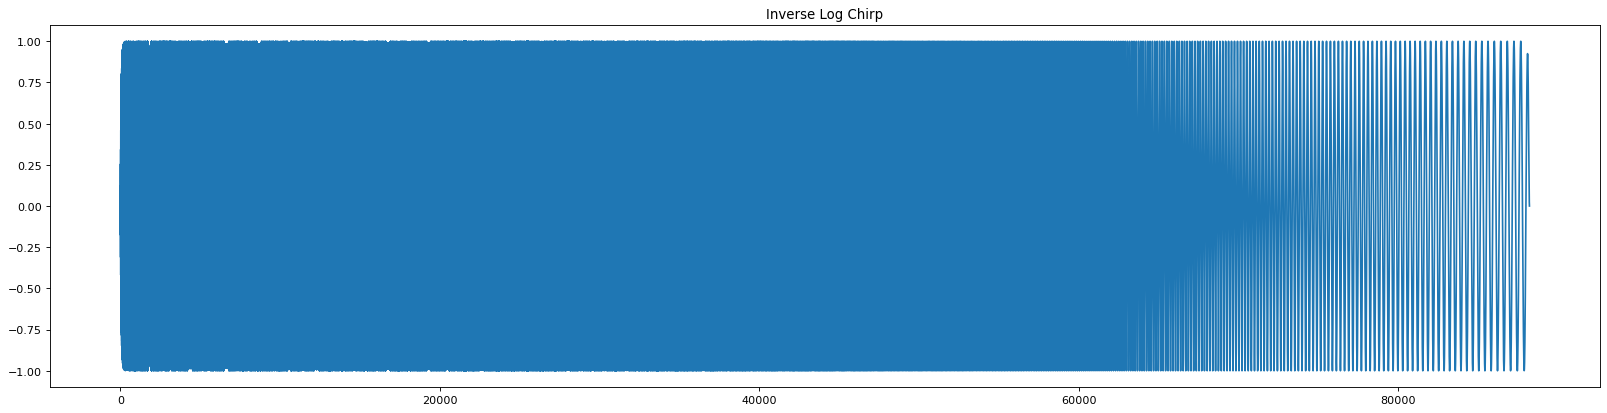

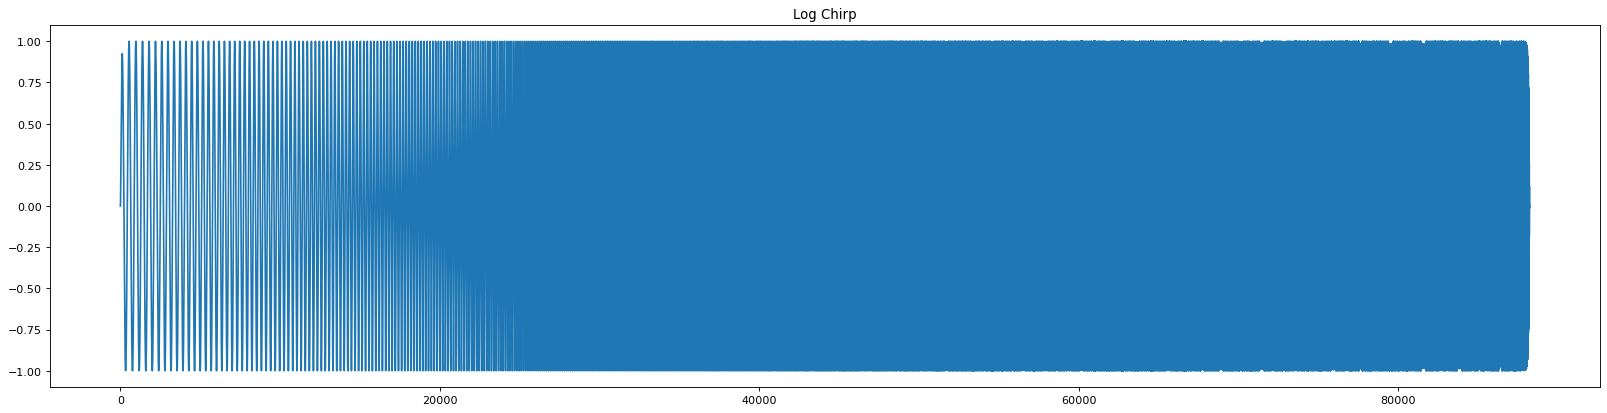

In [4]:
# linear or log chirp

sec = 2
k = 1000 # around 10?
fl = 100
fu = 6000

t = np.linspace(0, sec, int(fs*sec))

ch_lin = chirp(t, f0=fl, f1=fu, t1=sec, method='linear') # can be linear, quadratic or logarithmic
ch_lin *= (1-np.exp(-k*t))*(1-np.exp(-k*(sec-t))) /5 # /5 scale to match size of ofdm?
inv_ch_lin = np.flip(ch_lin)

# form of log chirp

ch_log = np.sin(2 * np.pi * fl * sec * (np.exp( t * (np.log(fu / fl) / sec)) -1) /np.log(fu / fl) )
ch_log *= (1-np.exp(-k*t))*(1-np.exp(-k*(sec-t)))
mod = np.exp(-t * np.log(fu / fl) / sec)
plt.figure(figsize=(25, 6), dpi=80)
inv_ch_log = np.flip(ch_log)
plt.title('Inverse Log Chirp')
plt.plot(inv_ch_log)

ch = ch_log
ch = np.tile(ch, 1) # repeat num chirps

T = 0.0 # delay
inv_ch = inv_ch_log
inv_ch = np.concatenate((np.zeros(int(T*fs)), inv_ch), axis=None) # time reverse and delay the chirp
plt.figure(figsize=(25, 6), dpi=80)
plt.title('Log Chirp')
plt.plot(ch)

Chirp 1 starts at: 0 Chirp ends at:  88200   OFDM starts at:  88200
Distance between chirp end & OFDM start:  0


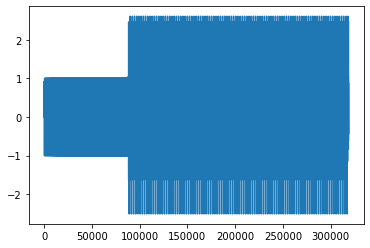

In [5]:
repeats = 100
repeat = np.tile(frame, repeats) # transmit repeated frames

gap = int(0*fs)
combined = np.concatenate((np.zeros(gap), ch, np.zeros(gap), repeat, np.zeros(gap)), axis=None)
print("Chirp 1 starts at:", gap, "Chirp ends at: ", gap+len(ch), "  OFDM starts at: ", (2*gap)+len(ch)) #, "Chirp 2 starts at: ", (3*gap)+len(ch)+len(repeat), "Dist between chirp starts: ", (2*gap)+len(ch)+len(repeat))
tx_diff = 2*gap + len(ch)
print("Distance between chirp end & OFDM start: ", gap)
plt.plot(combined)

Add the actual encoded signal 

In [6]:
filename='1.tiff'
bits_tran=file_to_bitstr(filename)
symbols_tran=encode_bitstr2symbols(bits_tran)
OFDM_frames_tran=symbol_to_OFDMframes(symbols_tran,N,prefix_no)


about to do encode_bitstr2symbols encoding
encode_bitstr2symbols encoding finished
about to do symbol_to_OFDMframes encoding
symbol_to_OFDMframes encoding finished


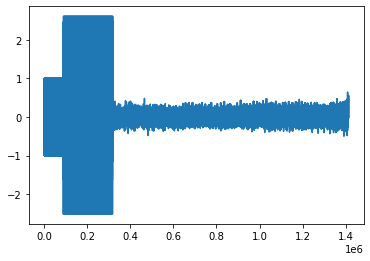

In [7]:
transmit = np.concatenate((combined, np.real(OFDM_frames_tran)), axis=None)
plt.plot(transmit)

32.0408843537415


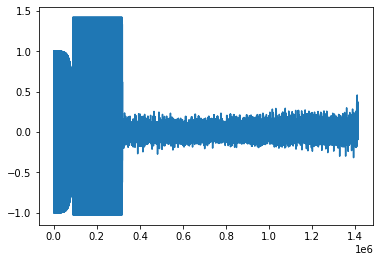

In [8]:
channel = [0.5, 0.25, 0, 0.25]
chan_fft = np.fft.fft(channel,N)
channel_op = np.convolve(channel, transmit)
plt.plot(channel_op)
print(len(channel_op)/fs)

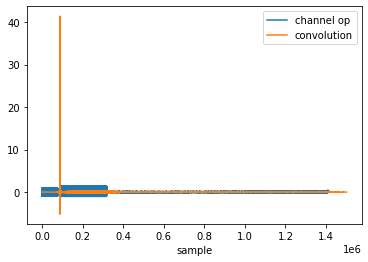

In [9]:
conv = np.convolve(channel_op, inv_ch)
plt.plot(channel_op, label='channel op')
plt.plot(conv/1000, label='convolution')
plt.xlabel('sample')
plt.legend(loc='upper right')
channel_dect = conv[0:250000]

Convolution peak 1: 88200


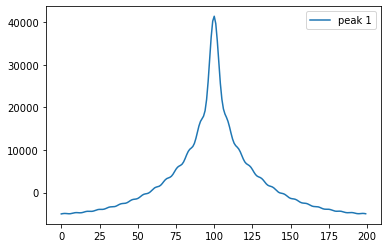

In [10]:
peak1 = np.argmax(channel_dect[0:int(len(channel_dect)/2)]) # checks first half of convoluted signal for peak
#peak2 = np.argmax(channel_dect[int(len(channel_dect)/2):]) + int(len(channel_dect)/2) + 0
print("Convolution peak 1:", peak1)
#print("Convolution peak 2:", peak2)
plt.plot(conv[peak1-100:peak1+100], label='peak 1')
#plt.plot(conv[peak2-100:peak2+100], label='peak 2')
plt.legend()
#print("Dist: ", peak2 - peak1)

2304
230400
230400


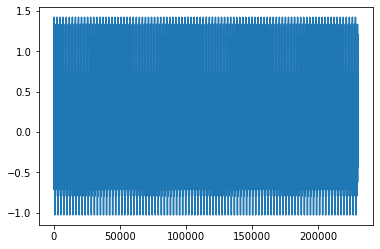

In [11]:
offset = 0 # current rough synchronisation error
print(len(frame))

rx_begin = peak1 + gap - + offset # channel IR adjusts this value
rx_OFDM = channel_op[rx_begin:rx_begin+len(repeat)] # for ideal sync
print(len(rx_OFDM))
#rev_pulse = np.flip(pulse)
#rx_OFDM = np.convolve(rx_signal, rev_pulse)
single_frame = rx_OFDM[0:len(frame)]
print(len(rx_OFDM))
plt.plot(rx_OFDM)

Diff:  0


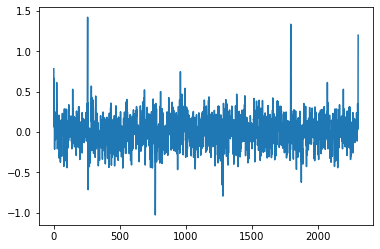

In [12]:
frames = np.split(rx_OFDM, repeats)
avg_frame = np.zeros(len(frame))
for frame in frames:
    avg_frame = np.add(avg_frame, frame)
avg_frame /= repeats
#print(avg_frame)
plt.plot(avg_frame)
print("Diff: ", rx_begin - ((2*gap)+len(ch))) 

[ 0.50268555-3.72350323e-18j  0.24560547-2.44140625e-04j
  0.00317383-4.39075685e-18j  0.24560547+2.44140625e-04j
  0.00268555+4.60356600e-18j -0.00439453-2.44140625e-04j
  0.00317383+4.50923495e-18j -0.00439453+2.44140625e-04j
  0.00268555-2.52011964e-19j -0.00439453-2.44140625e-04j]


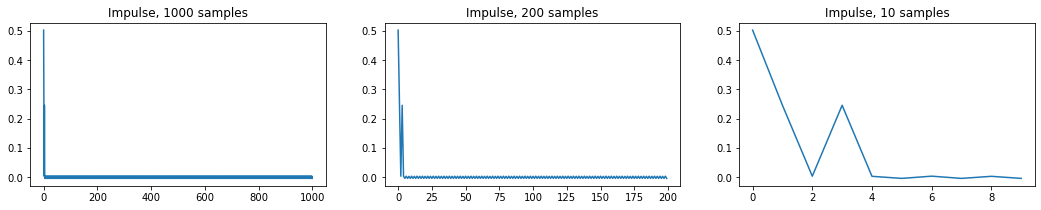

In [13]:
# remove cp, reduce to info symbols only

trim_frame = avg_frame[prefix_no: prefix_no+N]

rx_dft = np.fft.fft(trim_frame, N) # get info symbols stored

norm_rx_dft = []

for i in range(len(full_symbols)):
    #print(rx_dft[i], full_symbols[i], rx_dft[i] / full_symbols[i])
    norm_rx_dft = np.append(norm_rx_dft, rx_dft[i] / full_symbols[i])

#print(rx_dft[0], rx_dft[512])
#print(rx_dft[511], rx_dft[513])    

norm_rx_dft[512] = 0 # getting NaN otherwise

imp_response = np.fft.ifft(norm_rx_dft, N)

print(imp_response[0:10])
imp_response = np.real(imp_response)

figs, axs = plt.subplots(1, 3, figsize=(18,3))
axs[0].plot(imp_response[:1000])
axs[0].set_title('Impulse, 1000 samples')
axs[1].set_title('Impulse, 200 samples')
axs[1].plot(imp_response[:200])
axs[2].set_title('Impulse, 10 samples')
axs[2].plot(imp_response[:10])

REtrieve info:

In [14]:
#imp_response = [0.5,0.24,0,0.25]
channel_fft = np.fft.fft(imp_response, N)

In [15]:
Information = channel_op[rx_begin+len(repeat)+gap:-1]
print(Information.shape)

(1094402,)


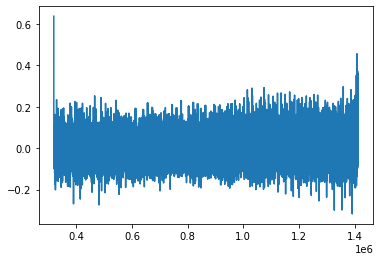

In [16]:
plt.plot(np.arange(rx_begin+len(repeat)+gap, len(channel_op)-1),Information)

In [17]:
Information = np.concatenate((Information, np.zeros(N+prefix_no - len(Information) % (N+prefix_no))), axis=None)
Information = Information.reshape((-1,N+prefix_no))
print(Information.shape)

(476, 2304)


In [18]:
bin_strings=OFDMframes_to_bitstring(Information,N,prefix_no, channel_fft=channel_fft)
bitstr_to_file(bin_strings,'decode.tiff')

about to do OFDMframes_to_bitstring decoding
OFDMframes_to_bitstring decoding finished
bitstr written to  decode.tiff
